In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb+')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [ ]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #param {type:"string"}

EXPERIMENT_TYPE = "Regenerating" #param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [ ]:
#@title CA Model and Utilities

from tensorflow.keras.layers import Conv2D

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  hexes = [hex(ord(e))[2:] for e in list(emoji)]
  if 'fe0f' in hexes:
    hexes.remove('fe0f')
  # print(hexes)

  code = "_".join(hexes)
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)


def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def get_living_mask(x):
  alpha = x[:, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x


class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle)
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x += dx * tf.cast(update_mask, tf.float32)

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)


CAModel().dmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (1, 3, 3, 128)            6272      
                                                                 
 conv2d_3 (Conv2D)           (1, 3, 3, 16)             2064      
                                                                 
Total params: 8336 (32.56 KB)
Trainable params: 8336 (32.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [ ]:
#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72)
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None]
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('drive/MyDrive/%s_train_log/pool_jpgs/%04d_pool.jpg'%(TARGET_EMOJI, step_i), tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('drive/MyDrive/%s_train_log/batches_jpgs/batches_%04d.jpg'%(TARGET_EMOJI, step_i), vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


['1f98e']


  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)



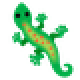

In [ ]:
#@title Choosing Target Image

target_img = load_emoji(TARGET_EMOJI)
imshow(zoom(to_rgb(target_img), 2), fmt='png')

In [ ]:
#@title Initialize Training

p = TARGET_PADDING
pad_target = tf.pad(target_img, [(p, p), (p, p), (0, 0)])
imshow(zoom(to_rgb(pad_target), 2), fmt='png')
h, w = pad_target.shape[:2]
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:] = 1.0

def loss_f(x):
  return tf.reduce_mean(tf.square(to_rgba(x)-pad_target), [-2, -3, -1])

ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.Adam(lr_sched)

loss0 = loss_f(seed).numpy()
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))

In [ ]:
#@title Directories declaration
pool_path = "drive/MyDrive/%s_train_log/pool_jpgs" % (TARGET_EMOJI)
batches_path = "drive/MyDrive/%s_train_log/batches_jpgs" % (TARGET_EMOJI)
!mkdir -p "$pool_path" && mkdir -p "$batches_path"

import pandas as pd
loss_df = pd.DataFrame(columns=['Loss', 'Log10(Loss)'])

batch (before/after):


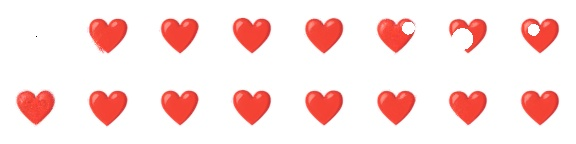

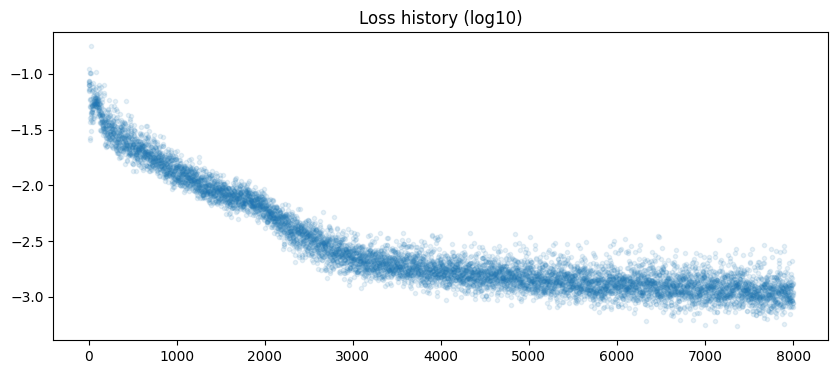

 step: 8001, log10(loss): -3.087

In [ ]:
#@title Training Loop

@tf.function
def train_step(x):
  iter_n = tf.random.uniform([], 64, 96, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

for i in range(8000+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    loss_rank = loss_f(x0).numpy().argsort()[::-1]
    x0 = x0[loss_rank]
    x0[:1] = seed
    if DAMAGE_N:
      damage = 1.0-make_circle_masks(DAMAGE_N, h, w).numpy()[..., None]
      x0[-DAMAGE_N:] *= damage
  else:
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

  x, loss = train_step(x0)
  loss_df = pd.concat([pd.DataFrame([[loss.numpy(), np.log10(loss)]], columns=loss_df.columns), loss_df], ignore_index=True)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())

  if step_i%10 == 0:
    generate_pool_figures(pool, step_i)
  if step_i%100 == 0:
    clear_output()
    visualize_batch(x0, x, step_i)
    plot_loss(loss_log)
    export_model(ca, 'drive/MyDrive/%s_train_log/%04d'%(TARGET_EMOJI, step_i))

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

# Figures

In [ ]:
#@title Training Progress (Checkpoints)

videos_path = "drive/MyDrive/%s_train_log/videos" % (TARGET_EMOJI)
!mkdir -p "$videos_path"

models = []
for i in [100, 500, 1000, 4000, 8000]:
  ca = CAModel()
  ca.load_weights('drive/MyDrive/%s_train_log/%04d'%(TARGET_EMOJI, i))
  models.append(ca)

out_fn = 'drive/MyDrive/%s_train_log/videos/train_steps_damage_%d.mp4'%(TARGET_EMOJI, DAMAGE_N)
x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
mvp.ipython_display(out_fn)

100%|██████████| 500/500 [00:12<00:00, 38.80it/s]


In [ ]:
#@title Training Progress (Batches)
frames = sorted(glob.glob('drive/MyDrive/%s_train_log/batches_jpgs/batches_*.jpg' % (TARGET_EMOJI)))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile(f"drive/MyDrive//{TARGET_EMOJI}_train_log/videos/batches.mp4")
mvp.ipython_display(f"drive/MyDrive//{TARGET_EMOJI}_train_log/videos/batches.mp4")

Moviepy - Building video drive/MyDrive//❤️_train_log/videos/batches.mp4.
Moviepy - Writing video drive/MyDrive//❤️_train_log/videos/batches.mp4



Moviepy - Done !
Moviepy - video ready drive/MyDrive//❤️_train_log/videos/batches.mp4


In [ ]:
#@title Pool Contents
frames = sorted(glob.glob('drive/MyDrive/%s_train_log/pool_jpgs/*_pool.jpg' % (TARGET_EMOJI)))[:400]
mvp.ImageSequenceClip(frames, fps=20.0).write_videofile(f"drive/MyDrive/{TARGET_EMOJI}_train_log/videos/pool.mp4")
mvp.ipython_display(f"drive/MyDrive//{TARGET_EMOJI}_train_log/videos/pool.mp4")

Moviepy - Building video drive/MyDrive/❤️_train_log/videos/pool.mp4.
Moviepy - Writing video drive/MyDrive/❤️_train_log/videos/pool.mp4



Moviepy - Done !
Moviepy - video ready drive/MyDrive/❤️_train_log/videos/pool.mp4


## Function for loading Saved Models

In [ ]:
def get_model(emoji='🦋', fire_rate=0.5, use_pool=1, damage_n=3, run=0,
              prefix='models/', output='model'):
  path = prefix
  assert output in ['model', 'json']
  if output == 'model':
    ca = CAModel(channel_n=16, fire_rate=fire_rate)
    ca.load_weights('drive/MyDrive/%s_train_log/%04d'%(TARGET_EMOJI, 8000))
    return ca
  elif output == 'json':
    return open(path+'.json', 'r').read()

In [ ]:
#@title Functions for saving as compatible WebGL Model

def pack_layer(weight, bias, outputType=np.uint8):
  in_ch, out_ch = weight.shape
  assert (in_ch%4==0) and (out_ch%4==0) and (bias.shape==(out_ch,))
  weight_scale, bias_scale = 1.0, 1.0
  if outputType == np.uint8:
    weight_scale = 2.0*np.abs(weight).max()
    bias_scale = 2.0*np.abs(bias).max()
    weight = np.round((weight/weight_scale+0.5)*255)
    bias = np.round((bias/bias_scale+0.5)*255)
  packed = np.vstack([weight, bias[None,...]])
  packed = packed.reshape(in_ch+1, out_ch//4, 4)
  packed = outputType(packed)
  packed_b64 = base64.b64encode(packed.tobytes()).decode('ascii')
  return {'data_b64': packed_b64, 'in_ch': in_ch, 'out_ch': out_ch,
          'weight_scale': weight_scale, 'bias_scale': bias_scale,
          'type': outputType.__name__}

def export_ca_to_webgl_demo(ca, outputType=np.uint8):
  # reorder the first layer inputs to meet webgl demo perception layout
  chn = ca.channel_n
  w1 = ca.weights[0][0, 0].numpy()
  w1 = w1.reshape(chn, 3, -1).transpose(1, 0, 2).reshape(3*chn, -1)
  layers = [
      pack_layer(w1, ca.weights[1].numpy(), outputType),
      pack_layer(ca.weights[2][0, 0].numpy(), ca.weights[3].numpy(), outputType)
  ]
  return json.dumps(layers)

In [ ]:
e = TARGET_EMOJI
with zipfile.ZipFile(f"drive/MyDrive/{e}_train_log/{e}_webgl_model.zip", 'w') as zf:
  ca_model = get_model(e, use_pool=1, damage_n=3)
  export_op = export_ca_to_webgl_demo(ca_model)
  zf.writestr('HUex3_%s.json'%e, export_op)

In [ ]:
loss_df.to_csv(f"drive/MyDrive/{e}_train_log/{e}_losses.csv")